# ```TIMESERIES & FORECASTING MINI PROJECT```

**Context :**

The historical sales data for 45 Walmart stores located in different regions are available. There are certain events and holidays which impact sales on each day. The business is facing a challenge due to unforeseen demands and runs out of stock some times, due to inappropriate machine learning algorithm. Walmart would like to forecast the sales and demand accurately.


**Data Description :**

Total 16 numbers of attributes are provided in the Data set including Target variable. Attribute definition is:
- Store: The store number
- Size: Size of the Store
- Dept: Department of the Store
- Date: Specifying the Week (Friday of every Week)
- Temperature: Average temperature in the region (in ℉)
- FuelPrice: Cost of fuel in the region
- MarkDown1-5: Anonymized data related to promotional markdowns that Walmart is running. Markdown data is only available after November 2011, and is not available for all stores all the time. Any missing value is marked with Null.
- CPI: Consumer price index
- Unemployment: Unemployment rate
- IsHoliday: Whether the week is a special holiday week

``link to originial dataset here`` : [kaggle](https://www.kaggle.com/datasets/divyajeetthakur/walmart-sales-prediction)

## IMPORT LIBRARIES

In [1]:
# data wrangling

import pandas as pd
import numpy as np
import datetime as dt
from math import sqrt

# data visualization

import matplotlib.pyplot as plt
import seaborn as sns

# modelling

import pmdarima as pm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# set option for pandas

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.0f' % x)

In [2]:
# import warning

import warnings
warnings.filterwarnings("ignore")

## OVERVIEW

In [3]:
# load data

df = pd.read_csv("https://raw.githubusercontent.com/CahyaPutera/FFI-Training-Dataset/main/walmart_train.csv")

## CONTINUE BELOW

In [4]:
df1 = df[["Date", "Weekly_Sales"]]

In [5]:
df1 = df1.rename(columns = {"Date":"date", "Weekly_Sales":"sales"})

In [6]:
df1 = df1.sort_values("date").reset_index(drop=True)

In [7]:
df1["date"] = pd.to_datetime(df1["date"])

In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282451 entries, 0 to 282450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    282451 non-null  datetime64[ns]
 1   sales   282451 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.3 MB


In [9]:
df1 = df1.set_index("date")

In [10]:
res = df1.resample("W").mean()

<AxesSubplot:xlabel='date'>

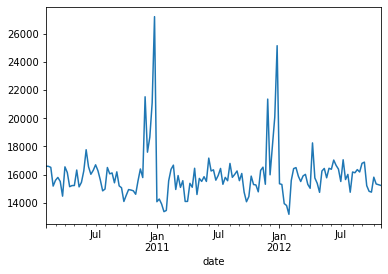

In [11]:
res["sales"].plot()

In [12]:
# check stationary

print("Is the data stationary ?")
dftest = adfuller(res.values, autolag='AIC')

print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")

for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

Is the data stationary ?
Test statistic = -6.102
P-value = 0.000
Critical values :
	1%: -3.47864788917503 - The data is  stationary with 99% confidence
	5%: -2.882721765644168 - The data is  stationary with 95% confidence
	10%: -2.578065326612056 - The data is  stationary with 90% confidence


In [13]:
train, test = train_test_split(res, test_size=0.4, shuffle=False)

In [14]:
train.shape

(85, 1)

In [15]:
test.shape

(58, 1)

In [16]:
# SARIMA

model_sarima = pm.auto_arima(train, seasonal = True) # seasonal = False is ARIMA, True is SARIMA

In [17]:
model_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   85
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -748.951
Date:                Fri, 29 Jul 2022   AIC                           1503.902
Time:                        00:50:11   BIC                           1511.230
Sample:                             0   HQIC                          1506.849
                                 - 85                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   9780.8689    966.367     10.121      0.000    7886.825    1.17e+04
ar.L1          0.3853      0.045      8.472      0.000       0.296       0.474
sigma2      2.657e+06   1.79e+05     14.847      0.000    2.31e+06    3.01e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):               815.16
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               1.13   Skew:                             2.22
Prob(H) (two-sided):                  0.75   Kurtosis:                        17.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
pred_sarima = model_sarima.predict(n_periods=58, seasonal = True)

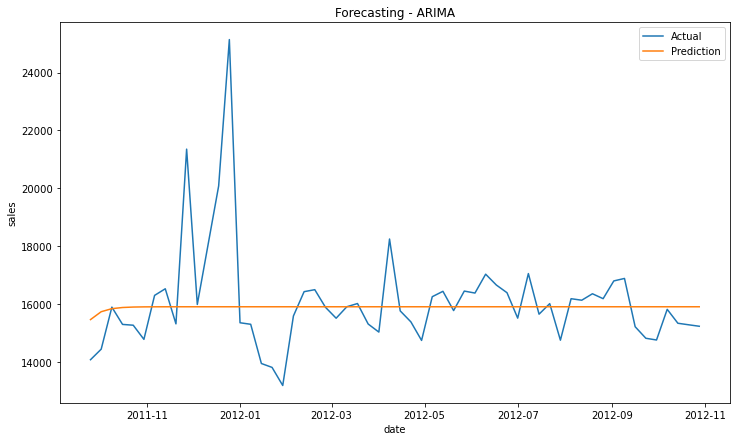

In [19]:
# plot SARIMA

plt.figure(figsize=(12,7))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, pred_sarima, label='Prediction')
plt.title('Forecasting - ARIMA')
plt.xlabel('date')
plt.ylabel('sales')
plt.legend()

In [20]:
# get rmse

sarima_RMSE = sqrt(mean_squared_error(test, pred_sarima))
print(f"Model Sarima RMSE = {round(sarima_RMSE, 2)}")

Model Sarima RMSE = 1765.5


In [21]:
# rolling SARIMA

pred_roll = []
act_roll = []

for i in test.values:
    output = model_sarima.predict(n_periods=1, seasonal=True)
    pred = list(output)[0]
    act = list(i)[0]
    pred_roll.append(pred)
    act_roll.append(act)
    model_sarima.update(list(i)[0])

In [22]:
model_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  143
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -1262.018
Date:                Fri, 29 Jul 2022   AIC                           2530.036
Time:                        00:50:13   BIC                           2538.924
Sample:                             0   HQIC                          2533.648
                                - 143                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   9780.8797    742.854     13.167      0.000    8324.913    1.12e+04
ar.L1          0.3876      0.036     10.691      0.000       0.317       0.459
sigma2      2.659e+06   1.51e+05     17.559      0.000    2.36e+06    2.96e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.52   Jarque-Bera (JB):               867.33
Prob(Q):                              0.47   Prob(JB):                         0.00
Heteroskedasticity (H):               0.64   Skew:                             2.10
Prob(H) (two-sided):                  0.12   Kurtosis:                        14.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

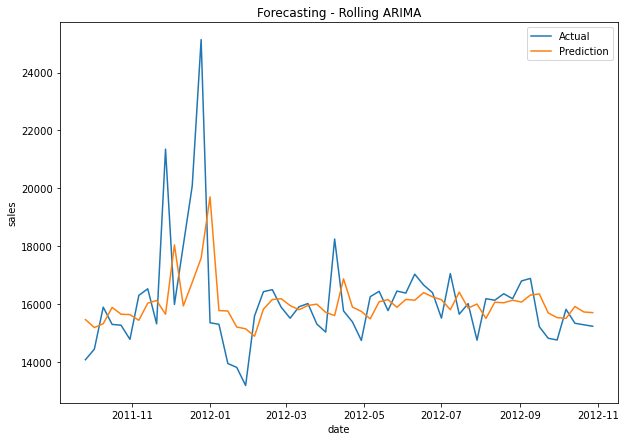

In [23]:
# plot rolling SARIMA

plt.figure(figsize=(10,7))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, pred_roll, label='Prediction')
plt.title('Forecasting - Rolling ARIMA')
plt.xlabel('date')
plt.ylabel('sales')
plt.legend()

In [24]:
# get rmse

roll_sarima_RMSE = sqrt(mean_squared_error(test, pred_roll))
print(f"Model Rolling Sarima RMSE = {round(roll_sarima_RMSE, 2)}")

Model Rolling Sarima RMSE = 1690.93


In [25]:
# set model

history = train
pred_tes = pd.Series()

for t in range(len(test)):
    model = ExponentialSmoothing(history, seasonal = "add")
    model_tes = model.fit(optimized=True)
    output = model_tes.forecast()
    pred_tes = pred_tes.append(output)
    item = test.iloc[[t]]
    history = history.append(item)

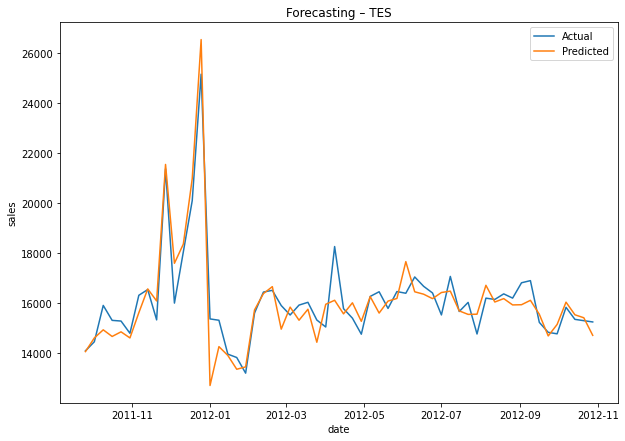

In [26]:
# plot model prediction vs actual

plt.figure(figsize=(10,7));
plt.plot(test.index, test, label='Actual');
plt.plot(test.index, pred_tes, label='Predicted');
plt.title('Forecasting – TES')
plt.xlabel('date')
plt.ylabel('sales')
plt.legend()
plt.show()

In [27]:
tes_RMSE = sqrt(mean_squared_error(test, pred_tes))
print(f"Model TES RMSE = {round(tes_RMSE, 2)}")

Model TES RMSE = 745.72


In [28]:
# function to plot future values

def plot_forecast(data, pred, n_periods, freq):
    
    #compile index and values
    index_of_fc = pd.date_range(data.index[-1], periods=n_periods, freq=freq)
    fitted_series = pd.Series(pred, index=index_of_fc)
    
    # plot forecasted
    plt.figure(figsize=(8,5))
    plt.plot(data, label = "Hist")
    plt.plot(fitted_series, label = "Forecast")
    plt.legend()
    plt.show()

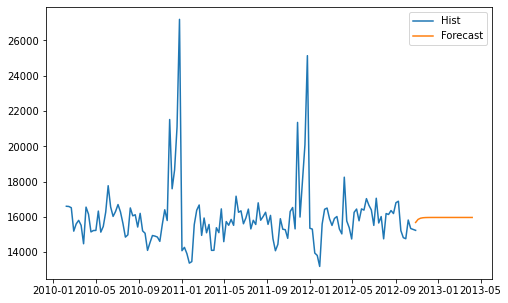

In [29]:
# plot sarima
n_period = 24
pred_sarima = model_sarima.predict(n_period)
plot_forecast(res, pred_sarima, n_period, "W")

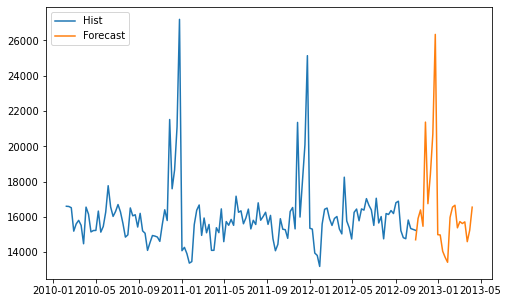

In [30]:
# plot tes
n_period = 24
pred_tes = model_tes.forecast(n_period)
plot_forecast(res, pred_tes, n_period, "W")